<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Time_series/Arima/AirPassengersTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Passengers Time Series

## Import libs

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, acf, pacf

In [2]:
%matplotlib inline

## Download dataset

In [3]:
%%capture
! wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Time_series/Arima/AirPassengers.csv

## First view of data

In [4]:
data = pd.read_csv('AirPassengers.csv')

In [5]:
data.columns

Index(['Month', '#Passengers'], dtype='object')

In [6]:
data.shape

(144, 2)

In [7]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


<Axes: >

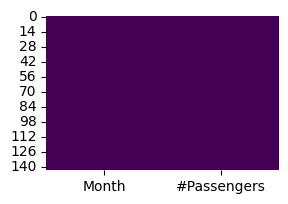

In [10]:
plt.figure(figsize=(3,2))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')

## Perform some transformations

In [21]:
df = data.copy()
df.index = pd.to_datetime(df['Month'])
#df.set_index('Month', inplace=True)
df.drop(['Month'], axis=1, inplace=True)
df = df.rename(columns={'#Passengers':'Passengers'})
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [22]:
monthmin = df.index.min()
monthmax = df.index.max()
display(monthmin)
display(monthmax)

Timestamp('1949-01-01 00:00:00')

Timestamp('1960-12-01 00:00:00')

In [24]:
df.resample('M').sum().tail()

,Passengers
Month,
1960-08-31,606
1960-09-30,508
1960-10-31,461
1960-11-30,390
1960-12-31,432


Emm we don't really need to explicitly set freq=M as of now.
Don't really want to convert 1960-12-01 to 1960-12-31 since we don't know the day colud be the last could be the first. After all we converted form YYYY-MM string format.
Anyways there should be any values but 1 for days.

In [25]:
any(timestamp.day != 1 for timestamp in df.index)

False

### Plot the time series

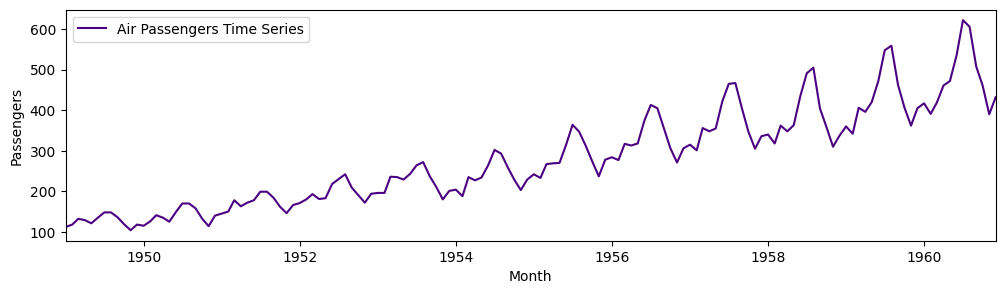

In [36]:
plt.figure(figsize=(12,3))
sns.lineplot(data=df, x=df.index, y='Passengers', label='Air Passengers Time Series', color='indigo')
plt.xlim(df.index.min(), df.index.max())
plt.show()

Peaks grow *higher* and *wider* thus we got **multiplicative** model

### Get rolling mean and std

In [46]:
rolling = df.rolling(window=12)
pd.concat([rolling.mean(), rolling.std()], keys= ['mean', 'std'], axis=1)

,mean,std
,Passengers,Passengers
Month,,
1949-01-01,NaN,NaN
1949-02-01,NaN,NaN
1949-03-01,NaN,NaN
1949-04-01,NaN,NaN
1949-05-01,NaN,NaN
...,...,...
1960-08-01,463.333333,83.630500
1960-09-01,467.083333,84.617276


## Check stationarity

### Moving average and rolling std

In [109]:
def get_ma_std(df):
  rolling = df.rolling(window=12)
  plt.figure(figsize=(10,3))
  sns.lineplot(data=df, x=df.index, y='Passengers', label='Data', color='indigo')
  sns.lineplot(rolling.mean()['Passengers'], label='mean', color='red')
  sns.lineplot(rolling.std()['Passengers'], label='std', color='magenta')
  plt.show()

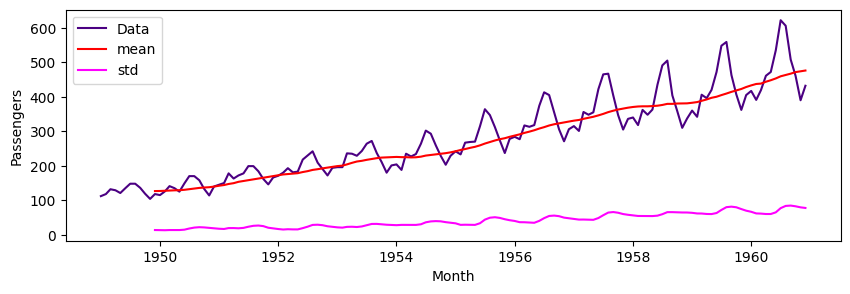

In [102]:
get_ma_std(df)

### Dickey-Fuller test for stationarity

In [117]:
def test_stationarity(df):
  get_ma_std(df)
  fuller = adfuller(df, autolag='AIC')
  fuller_result = pd.Series(fuller[:4], index = ['Statistics', 'p-value', 'Lags', 'Observations num'])
  for key, value in fuller[4].items():
    fuller_result[f'Critical value {key}'] = value
  return pd.DataFrame(fuller_result, columns = ['result']).apply(lambda x: round(x, 3))

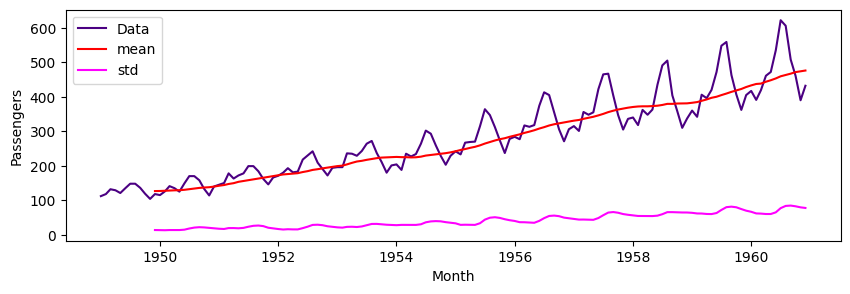

,result
Statistics,0.815
p-value,0.992
Lags,13.000
Observations num,130.000
Critical value 1%,-3.482
Critical value 5%,-2.884
Critical value 10%,-2.579


In [118]:
test_stationarity(df)

p-value 0.992 means the data is most probably(99% duh) non-stationary.
ADF statistics 0.815 is far away from the absolute Critical values thus we cannot reject the null-hypothesis that the data is stationary.
Ergo, data is **not stationary**.

## Decompose

In [82]:
decomp = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

### Trend

<Axes: xlabel='Month'>

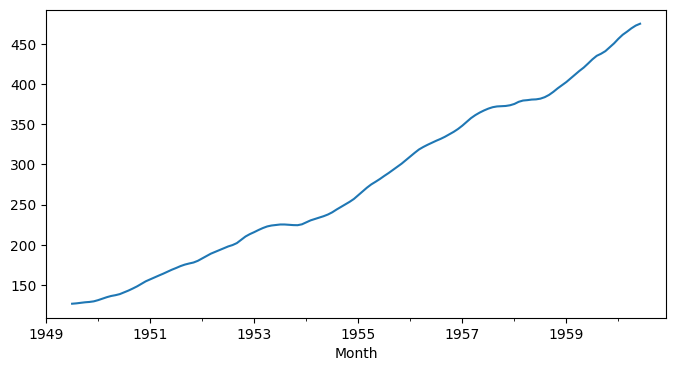

In [83]:
plt.figure(figsize=(8,4))
decomp.trend.plot()

Clearly **upward** trend

### Seasonal

<Axes: xlabel='Month'>

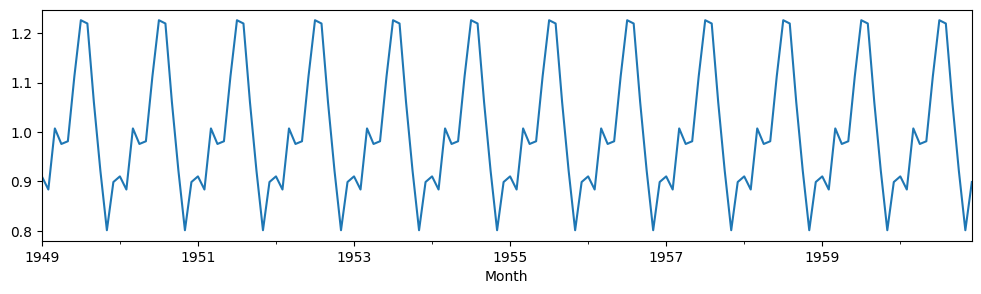

In [84]:
plt.figure(figsize=(12, 3))
decomp.seasonal.plot()

**One-year** seasonality

### Residuals

<Axes: xlabel='Month'>

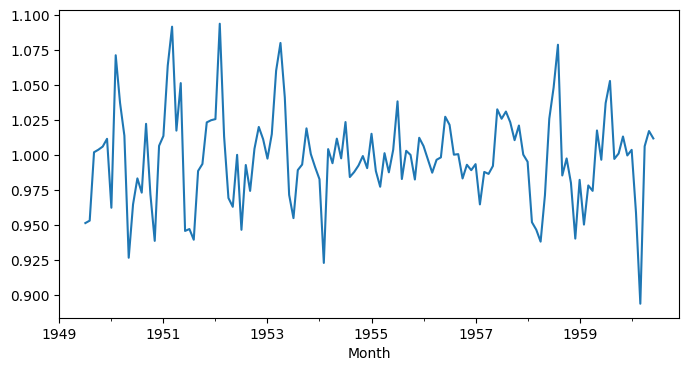

In [85]:
plt.figure(figsize=(8,4))
decomp.resid.plot()

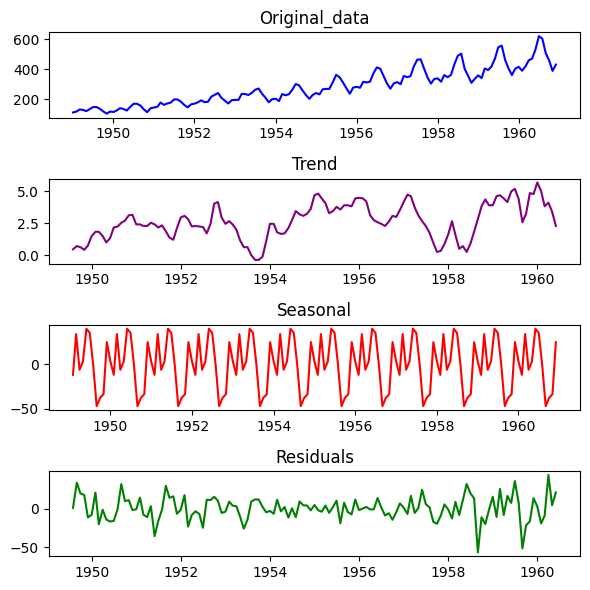

In [96]:
df_diff = df.diff().dropna()
diff_dec = sm.tsa.seasonal_decompose(df_diff, period=12)
fig, axes = plt.subplots(4, 1, figsize=(6, 6))

axes[0].plot(df.index, df['Passengers'], color='blue')
axes[0].set_title('Original_data')
axes[1].plot(diff_dec.trend, color='purple')
axes[1].set_title('Trend')
axes[2].plot(diff_dec.seasonal, color='red')
axes[2].set_title('Seasonal')
axes[3].plot(diff_dec.resid, color='green')
axes[3].set_title('Residuals')
plt.tight_layout()

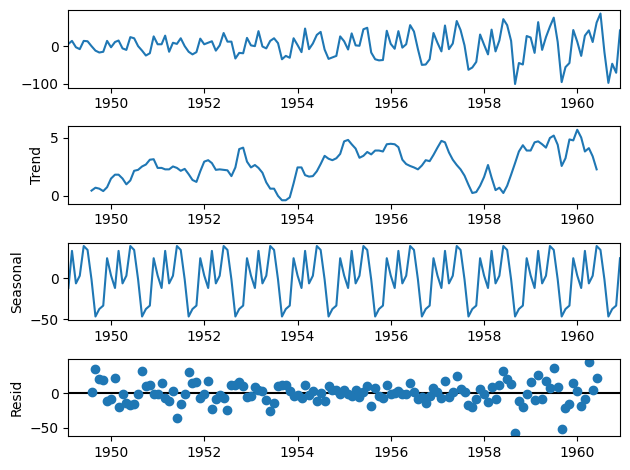

In [100]:
decplot = diff_dec.plot()
decplot.show()

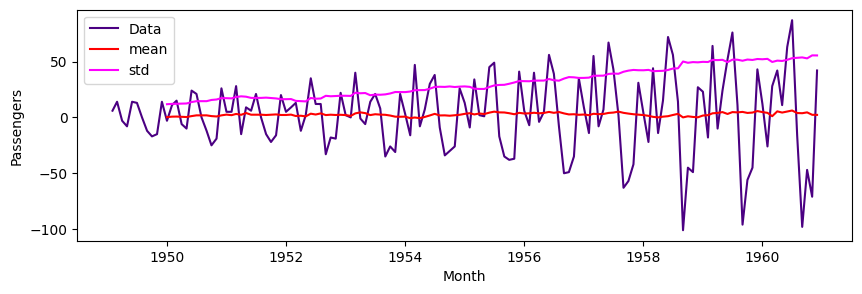

,result
Statistics,-2.829
p-value,0.054
Lags,12.000
Observations num,130.000
Critical value 1%,-3.482
Critical value 5%,-2.884
Critical value 10%,-2.579


In [119]:
test_stationarity(df_diff)

Now **p-value** is ~0.054 which **fails** by half of percent the 5% significance but it's way better than 0.992
**ADF statistics** result is **very close** to **critical value of 5%**
**Mean** is about **zero**
**STD** has an **upward** trend though

### For current task let's consider that acceptable transformation

But for the sake of **experiment**, let's perform **double difference**

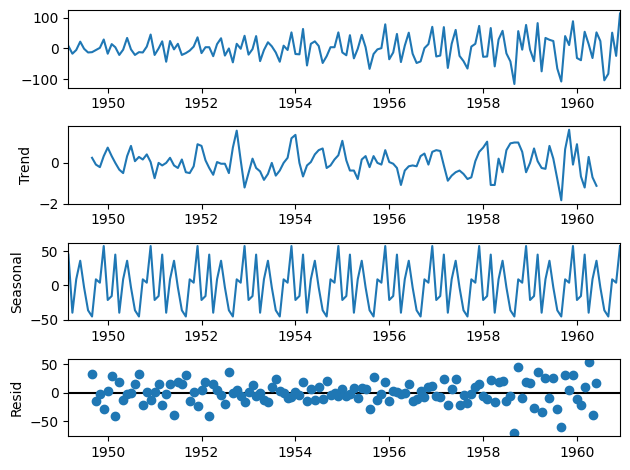

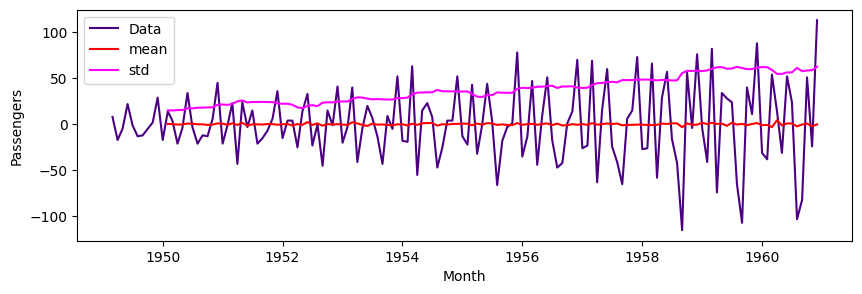

,result
Statistics,-16.384
p-value,0.000
Lags,11.000
Observations num,130.000
Critical value 1%,-3.482
Critical value 5%,-2.884
Critical value 10%,-2.579


In [124]:
double_diff = df_diff.diff().dropna()
dddec = sm.tsa.seasonal_decompose(double_diff, period=12).plot()
plt.show()
test_stationarity(double_diff)

We stil **got seasonality**, **no** particular **trend**,** p-value** is very low, approaching **zero** and **ADF statistics** is **lower than critical values**.

We assume such double **transformation would affect data too much**, so let's stick with just one diff() instead of the double.